In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
import re
import math
import unicodedata
from mpl_toolkits.mplot3d import Axes3D

# various options in pandas
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)
def doltoint(st):
    try:
        return float(''.join(''.join(st.split(',')).split('$')))
    except:
        return np.NaN
def OpGrossFix(st):
    return float(st.split('(')[0])
def prettyBudg(st):
    if st[-7::]=='million':
        return float(st.split(' ')[0].split('$')[1])*1000000
    elif st == 'N/A':
        return np.NaN
    else:
        return doltoint(st)
def prettyRun(st):
    t1 = []
    for i in st.split(' '):
        try:
            t1.append(int(i))
        except:
            pass     
    if len(t1)==2:
        return 60*t1[0] + t1[1]
    elif len(t1) == 1:
        return t1[0]
def month(st):
    if(st=='January'):
        return '01'
    elif(st=='February'):
        return '02'
    elif(st=='March'):
        return '03'
    elif(st=='April'):
        return '04'
    elif(st=='May'):
        return '05'
    elif(st=='June'):
        return '06'
    elif(st=='July'):
        return '07'
    elif(st=='August'):
        return '08'
    elif(st=='September'):
        return '09'
    elif(st=='October'):
        return '10'
    elif(st=='November'):
        return '11'
    elif(st=='December'):
        return '12'
    else:
        return 'SOMETHING BAD HAPPENED'
def cleanDay(st):
    if(len(st)==1):
        return '0' + st
    else:
        return st
def cleanDate(st):
    t=st.split(' ')
    return month(t[0])+cleanDay(t[1][:-1])+t[2]
df = pd.read_json('movies3t.json', orient = 'records', dtype={"url":str})
df = df[df.totalDomesticGross != 'Missing']
df = df[df.OpGross != 'NaN']
df = df[df.Budget != 'N/A']
df['OpGross'] = [OpGrossFix(x) for x in df['OpGross']]
df['noTheaters'] = [int(re.sub('[^0-9]','',x)) for x in df['noTheaters']]
df['RunTime'] = [ prettyRun(x) for x in df['RunTime']]
df['avOpGrossPTheater'] = [doltoint(x) for x in df['avOpGrossPTheater']]
df['totalDomesticGross'] = [doltoint(x) for x in df['totalDomesticGross']]
df['Budget'] = [prettyBudg(x) for x in df['Budget']]
df['Distributor'] = [str(x) for x in df['Distributor']]
df['Genre'] = [str(x) for x in df['Genre']]
df['Rating'] = [str(x) for x in df['Rating']]
df['actor'] = [unicodedata.normalize('NFKD', x) for x in df['actor']]
df['composer'] = [str(x) for x in df['composer']]
df['director'] = [unicodedata.normalize('NFKD', x) for x in df['director']]
df['name'] = [unicodedata.normalize('NFKD',x) for x in df['name']]
df['writer'] = [unicodedata.normalize('NFKD',x) for x in df['writer']]
df['ReleaseDate'] = [str(x) for x in df['ReleaseDate']]
df['ReleaseDate'] = pd.to_datetime([cleanDate(x) for x in df['ReleaseDate']], format = '%m%d%Y')
del df['url']
df['ROI'] = [x/y for x,y in zip(df['totalDomesticGross'], df['Budget'])]


/Users/subramanianiyer/anaconda2/envs/mypython3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ImportError: cannot import name 'plt'

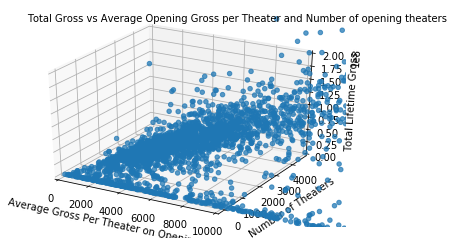

In [14]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.text2D(0.05, 0.95, "Total Gross vs Average Opening Gross per Theater and Number of opening theaters", transform=ax.transAxes)
ax.scatter(df['avOpGrossPTheater'], df['noTheaters'], df['totalDomesticGross'])
ax.set_xlabel('Average Gross Per Theater on Opening Night')
ax.set_ylabel('Number of Theaters')
ax.set_zlabel('Total Lifetime Gross')
ax.set_xlim(0,10000)
ax.set_zlim(0,200000000)
plt.show(ax)

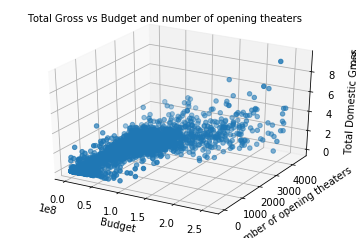

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.text2D(0.05, 0.95, "Total Gross vs Budget and number of opening theaters", transform=ax.transAxes)
ax.scatter(df['Budget'], df['noTheaters'], df['totalDomesticGross'])
ax.set_xlabel('Budget')
ax.set_ylabel('number of opening theaters')
ax.set_zlabel('Total Domestic Gross')
#ax.set_xlim(0,10000)
#ax.set_zlim(0,50000000)
plt.show(ax)

In [22]:
df.corr()

,Budget,OpGross,RunTime,avOpGrossPTheater,noTheaters,totalDomesticGross,ROI
Budget,1.000,0.679,0.309,0.094,0.600,0.637,-0.035
OpGross,0.679,1.000,0.194,0.080,0.640,0.868,-0.019
RunTime,0.309,0.194,1.000,0.097,-0.001,0.261,-0.025
avOpGrossPTheater,0.094,0.080,0.097,1.000,-0.190,0.252,0.010
noTheaters,0.600,0.640,-0.001,-0.190,1.000,0.505,-0.048
totalDomesticGross,0.637,0.868,0.261,0.252,0.505,1.000,0.015
ROI,-0.035,-0.019,-0.025,0.010,-0.048,0.015,1.000


In [30]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('totalDomesticGross ~ OpGross + Budget + RunTime + avOpGrossPTheater + noTheaters', data=df, return_type="dataframe")
# Create your model
model = sm.OLS(y, X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     totalDomesticGross   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     2112.
Date:                Tue, 23 Jan 2018   Prob (F-statistic):               0.00
Time:                        22:57:52   Log-Likelihood:                -51551.
No. Observations:                2744   AIC:                         1.031e+05
Df Residuals:                    2738   BIC:                         1.031e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.212e+07   4.35e+06     -5.089      0.000   -3.06e+07   -1.36e+07
OpGross               2.7749      0.045     62.110      0.000       2.687       2.863
Budget                0.1023      0.023      4.545      0.000       0.058       0.146
RunTime            2.686e+05   3.76e+04      7.144      0.000    1.95e+05    3.42e+05
avOpGrossPTheater   545.4533     29.742     18.339      0.000     487.134     603.773
noTheaters        -1194.2379    776.058     -1.539      0.124   -2715.957     327.481
==============================================================================
Omnibus:                     2407.639   Durbin-Watson:                   1.542
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           153282.467
Skew:                           3.842   Prob(JB):                         0.00
Kurtosis:                      38.800   Cond. No.                     4.42e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.42e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

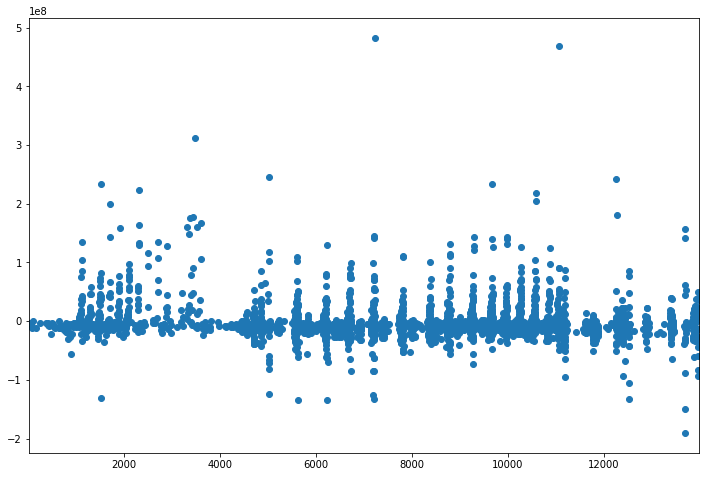

In [31]:
fit.resid.plot(style='o', figsize=(12,8))
plt.show()

I used a linear regression to predict Total Gross based on Budget, Opening Gross, Run time, average opening gross per theater, and the number of opening theaters. The R^2 was .794.  Interestingly, predicting total gross based on opening gross alone scores an R^2 of .868, so if I don't find a better scoring model, I'll just do that.  The residual plot is not random, so I'll have to look into that.  I tried to gain some insights from some 3d plots to no avail.  Steps for tomorrow:
1) Normalize numeric data
2) one-hot categorical data (actor, genre, rating, director, composer, writer)
3) Add features of all numeric data to degree 3 with step size 1/2.
4) Take cross validation steps
5) Use ridge regression to automate selection of features.
6) Compile Results to Presentation